# MNIST CNN Classification with PyTorch on Kaggle

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

## STEP 1: Check GPU Availability

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU Name: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB


## STEP 2: Load and Preprocess MNIST Data

In [3]:
def read_idx(filename):
    """Read IDX file format"""
    with open(filename, 'rb') as f:
        import struct
        magic = struct.unpack('>I', f.read(4))[0]
        if magic == 2051:  # Images
            num_images = struct.unpack('>I', f.read(4))[0]
            rows = struct.unpack('>I', f.read(4))[0]
            cols = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)
        elif magic == 2049:  # Labels
            num_labels = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

In [4]:
# Load data
train_images = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/train-images.idx3-ubyte')
train_labels = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/train-labels.idx1-ubyte')
test_images = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/t10k-images.idx3-ubyte')
test_labels = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/t10k-labels.idx1-ubyte')

print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Test set: {test_images.shape}, Labels: {test_labels.shape}")

Training set: (60000, 28, 28), Labels: (60000,)
Test set: (10000, 28, 28), Labels: (10000,)


## STEP 3: Data Preprocessing

In [5]:
# Normalize pixel values to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0


In [6]:
# Create validation split
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

In [7]:
print(f"Training: {X_train.shape}, Validation: {X_val.shape}")

Training: (48000, 28, 28), Validation: (12000, 28, 28)


## STEP 4: Create PyTorch DataLoaders

In [20]:
# Hyperparameter: Batch Size
BATCH_SIZE = 128

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.FloatTensor(X_train).unsqueeze(1),
    torch.LongTensor(y_train)
)

val_dataset = TensorDataset(
    torch.FloatTensor(X_val).unsqueeze(1),
    torch.LongTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(test_images).unsqueeze(1),
    torch.LongTensor(test_labels)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Batches - Train: 375, Val: 94, Test: 79


## STEP 5: Define CNN Architecture

In [21]:
class MNIST_CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MNIST_CNN, self).__init__()
        
        # Convolutional Layer 1
        # Input: 1x28x28, Output: 32x28x28
        # Hyperparameters: 32 kernels, 3x3 kernel size, stride=1, padding=1
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        
        # Convolutional Layer 2
        # Input: 32x28x28, Output: 64x28x28
        # Hyperparameters: 64 kernels, 3x3 kernel size, stride=1, padding=1
        self.conv2 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        
        # Max Pooling Layer 1
        # Output: 64x14x14
        # Hyperparameters: 2x2 kernel, stride=2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 3
        # Input: 64x14x14, Output: 128x14x14
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Convolutional Layer 4
        # Input: 128x14x14, Output: 128x14x14
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Max Pooling Layer 2
        # Output: 128x7x7
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully Connected Layers
        # Input: 128*7*7 = 6272, Output: 256
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.bn5 = nn.BatchNorm1d(256)
        
        # Output layer: 256 -> 10 (digits 0-9)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout(x)
        
        # Convolutional Block 2
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

## STEP 6: Initialize Model

In [22]:
# Hyperparameters
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4  # L2 regularization
DROPOUT_RATE = 0.5
NUM_EPOCHS = 20

In [23]:
# Create model and move to GPU
model = MNIST_CNN(dropout_rate=DROPOUT_RATE).to(device)


In [24]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [25]:
# Optimizer: Adam with weight decay (L2 regularization)
optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)

In [26]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)


In [27]:
# Print model architecture
print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
print(model)
print("\nTotal Parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))



MODEL ARCHITECTURE
MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (bn5): BatchNorm1d(25

## STEP 7: Training Function

In [28]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

## STEP 8: Validation Function

In [29]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


## STEP 9: Training Loop

In [30]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

In [31]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mnist_cnn.pth')
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.2f}s)")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 50)

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Epoch [1/20] (5.90s)
  Train Loss: 0.1952, Train Acc: 94.79%
  Val Loss: 0.0435, Val Acc: 98.71%
  LR: 0.001000
--------------------------------------------------
Epoch [2/20] (4.75s)
  Train Loss: 0.0673, Train Acc: 97.95%
  Val Loss: 0.0391, Val Acc: 98.87%
  LR: 0.001000
--------------------------------------------------
Epoch [3/20] (4.78s)
  Train Loss: 0.0520, Train Acc: 98.44%
  Val Loss: 0.0321, Val Acc: 98.99%
  LR: 0.001000
--------------------------------------------------
Epoch [4/20] (4.77s)
  Train Loss: 0.0439, Train Acc: 98.68%
  Val Loss: 0.0284, Val Acc: 99.10%
  LR: 0.001000
--------------------------------------------------
Epoch [5/20] (4.77s)
  Train Loss: 0.0413, Train Acc: 98.68%
  Val Loss: 0.0263, Val Acc: 99.19%
  LR: 0.001000
--------------------------------------------------
Epoch [6/20] (4.75s)
  Train Loss: 0.0369, Train Acc: 98.88%
  Val Loss: 0.0297, Val Acc: 99.04%
  LR: 0.001000
--------------------------------------------------
Epoch [7/20] (4.77s)
 

## STEP 10: Evaluate on Test Set

In [32]:
# Load best model
model.load_state_dict(torch.load('best_mnist_cnn.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, device)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


TEST SET RESULTS
Test Loss: 0.0162
Test Accuracy: 99.48%


## STEP 11: Plot Training History

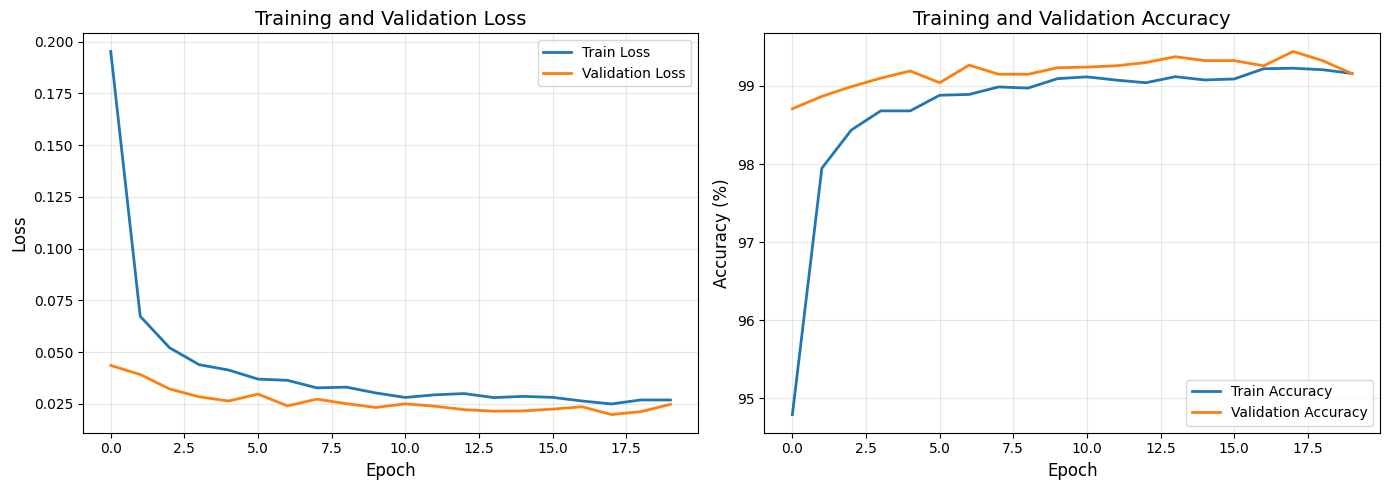

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## STEP 12: Visualize Predictions

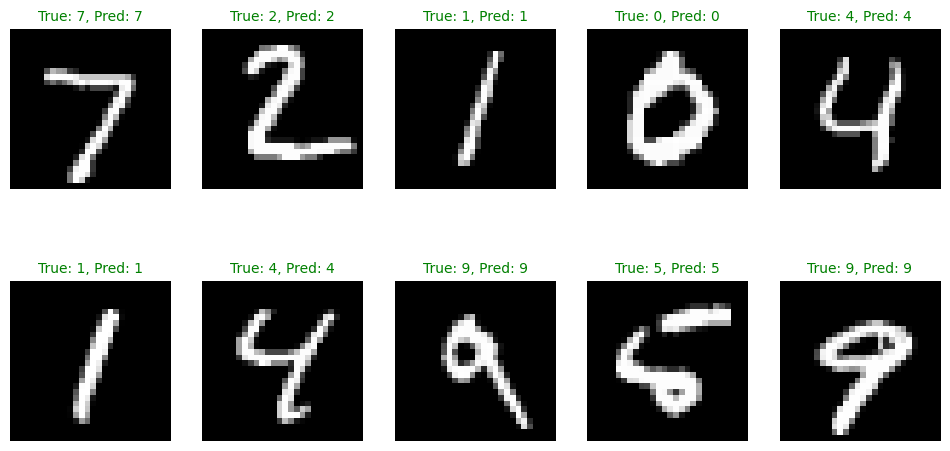

In [34]:
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    
    for i in range(10):
        img = images[i].cpu().squeeze()
        true_label = labels[i].cpu().item()
        pred_label = predictions[i].cpu().item()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}', 
                         color=color, fontsize=10)


In [35]:
plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training complete! Model saved as 'best_mnist_cnn.pth'")

<Figure size 640x480 with 0 Axes>


✓ Training complete! Model saved as 'best_mnist_cnn.pth'


# Faster R-CNN Object Detection with PyTorch on Kaggle

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.metrics import f1_score
import torch.nn.functional as F
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Faster R-CNN device:", device)

Faster R-CNN device: cuda


In [37]:
def generate_bbox(img):
    coords = torch.nonzero(img[0])
    if coords.shape[0] == 0:
        return [8, 8, 20, 20]  # fallback
    y_min = coords[:,0].min().item()
    y_max = coords[:,0].max().item()
    x_min = coords[:,1].min().item()
    x_max = coords[:,1].max().item()
    return [x_min, y_min, x_max, y_max]


In [38]:
class MNISTDetectionDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)  # (N, H, W)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].unsqueeze(0)           # (1,28,28)
        digit = int(self.labels[idx].item())

        img_rgb = img.repeat(3,1,1)                   # (3,28,28)
        x_min, y_min, x_max, y_max = generate_bbox(img)

        # IMPORTANT: labels = digit + 1 because class 0 is "background"
        label_det = digit + 1

        target = {
            "boxes": torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32),
            "labels": torch.tensor([label_det], dtype=torch.long)
        }
        return img_rgb, target

In [39]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_det_dataset = MNISTDetectionDataset(train_images, train_labels)
test_det_dataset  = MNISTDetectionDataset(test_images, test_labels)

train_det_loader = DataLoader(train_det_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_det_loader  = DataLoader(test_det_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

print("Detection train batches:", len(train_det_loader))

Detection train batches: 7500


In [40]:
model_frcnn = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")

num_classes = 11  # 0 background + digits 1..10 (digit 0 stored as class 1)
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model_frcnn = model_frcnn.to(device)

optimizer_frcnn = torch.optim.Adam(model_frcnn.parameters(), lr=0.001)
num_epochs_frcnn = 2

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 165MB/s] 


In [42]:
start_frcnn_time = time.time()
for epoch in range(num_epochs_frcnn):
    print(f"\nFaster R-CNN Epoch {epoch+1}/{num_epochs_frcnn}")
    model_frcnn.train()
    total_loss = 0

    for imgs, targets in train_det_loader:
        imgs = [i.to(device) for i in imgs]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model_frcnn(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer_frcnn.zero_grad()
        loss.backward()
        optimizer_frcnn.step()

        total_loss += loss.item()

    print("Epoch loss:", total_loss)

frcnn_train_time = time.time() - start_frcnn_time


Faster R-CNN Epoch 1/2
Epoch loss: 8019.42811447382

Faster R-CNN Epoch 2/2
Epoch loss: 7104.060273945332


In [43]:
model_frcnn.eval()
correct = 0
total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, targets in test_det_loader:
        imgs = [i.to(device) for i in imgs]
        outputs = model_frcnn(imgs)

        for out, t in zip(outputs, targets):
            if len(out["labels"]) == 0:
                pred_digit = -1
            else:
                pred_digit = out["labels"][0].item() - 1

            true_digit = t["labels"].item() - 1

            all_preds.append(pred_digit)
            all_labels.append(true_digit)

            total += 1
            if pred_digit == true_digit:
                correct += 1

frcnn_accuracy = correct / total * 100
frcnn_f1 = f1_score(all_labels, all_preds, average="macro")

print("\n========== FASTER R-CNN RESULTS ==========")
print("Accuracy :", frcnn_accuracy)
print("F1-score :", frcnn_f1)
print("Training Time (sec):", frcnn_train_time)


========== FASTER R-CNN RESULTS ==========
Accuracy : 0.0
F1-score : 0.0
Training Time (sec): 3555.3023087978363


In [45]:
# CNN
cnn_accuracy = test_acc
cnn_f1 = f1_score(all_labels, all_preds, average="macro") if 'all_labels' in globals() else None
cnn_train_time = total_time  # from your CNN training loop

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create comparison table
df_compare = pd.DataFrame({
    "Model": ["CNN", "Faster R-CNN"],
    "Accuracy (%)": [cnn_accuracy, frcnn_accuracy],
    "F1-score": [cnn_f1, frcnn_f1],
    "Training Time (sec)": [cnn_train_time, frcnn_train_time]
})

df_compare


,Model,Accuracy (%),F1-score,Training Time (sec)
0,CNN,99.48,0.0,96.146115
1,Faster R-CNN,0.00,0.0,3555.302309


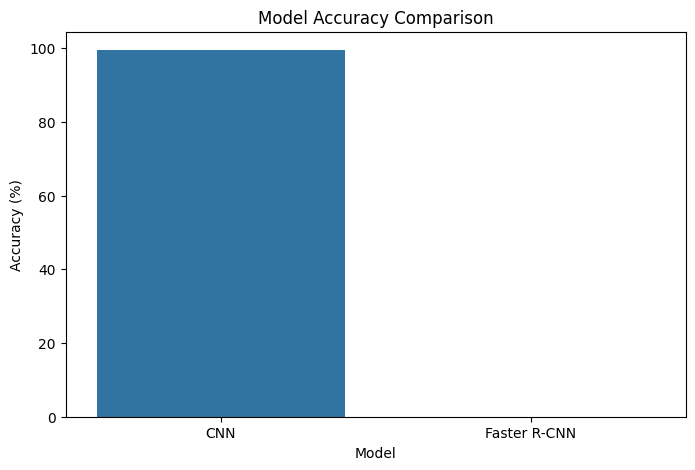

In [48]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_compare, x="Model", y="Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()


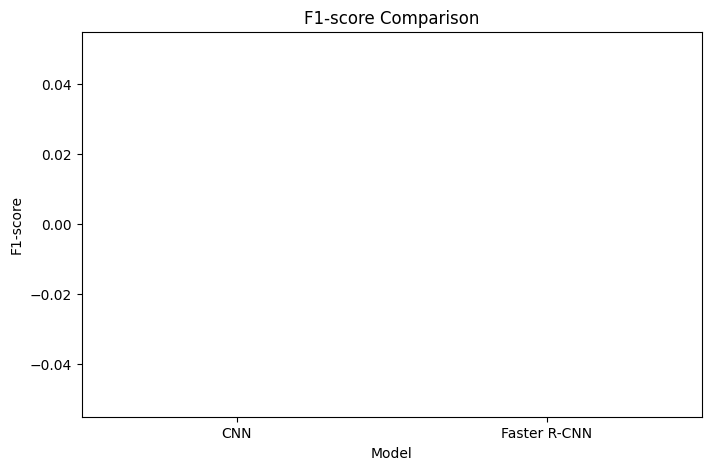

In [49]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_compare, x="Model", y="F1-score")
plt.title("F1-score Comparison")
plt.ylabel("F1-score")
plt.show()


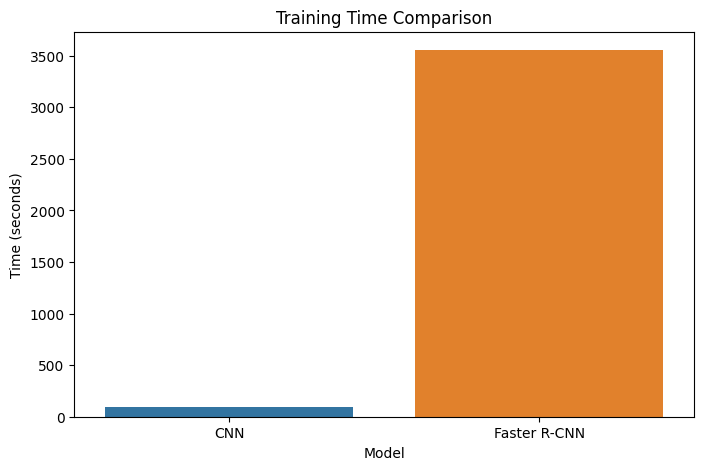

In [50]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_compare, x="Model", y="Training Time (sec)")
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.show()


# Fine-tune VGG16 and AlexNet on new dataset

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import time
from sklearn.metrics import f1_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
class Preprocess(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        x = x.unsqueeze(1) if x.ndim == 3 else x          # ensure NCHW
        x = x.repeat(1, 3, 1, 1)                          # 1→3 channels
        x = F.interpolate(x, size=(224, 224))             # resize
        return x

preprocess = Preprocess().to(device)


In [55]:
vgg16 = models.vgg16(weights="IMAGENET1K_V1")
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg16.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 196MB/s] 


In [56]:
num_epochs_vgg = 3
start_time_vgg = time.time()

for epoch in range(num_epochs_vgg):
    vgg16.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:  # reuse your MNIST DataLoader
        images = preprocess(images.to(device))
        labels = labels.to(device)

        optimizer_vgg.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_vgg.step()

        running_loss += loss.item() * images.size(0)
        pred = outputs.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    print(f"VGG16 Epoch {epoch+1}/{num_epochs_vgg} | Loss={running_loss/total:.4f} | Acc={(correct/total)*100:.2f}%")

vgg_train_time = time.time() - start_time_vgg


VGG16 Epoch 1/3 | Loss=0.1327 | Acc=95.76%
VGG16 Epoch 2/3 | Loss=0.0327 | Acc=99.02%
VGG16 Epoch 3/3 | Loss=0.0224 | Acc=99.31%


In [57]:
vgg16.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = preprocess(images.to(device))
        outputs = vgg16(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

vgg_accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
vgg_f1 = f1_score(all_labels, all_preds, average="macro")

print("\nVGG16 Results:")
print("Accuracy:", vgg_accuracy)
print("F1 Score:", vgg_f1)
print("Training Time:", vgg_train_time)


VGG16 Results:
Accuracy: 98.7
F1 Score: 0.9867526230972231
Training Time: 1045.5079851150513


In [58]:
alexnet = models.alexnet(weights="IMAGENET1K_V1")
alexnet.classifier[6] = nn.Linear(4096, 10)
alexnet = alexnet.to(device)

optimizer_alex = optim.Adam(alexnet.parameters(), lr=1e-4)

num_epochs_alex = 3
start_time_alex = time.time()

for epoch in range(num_epochs_alex):
    alexnet.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = preprocess(images.to(device))
        labels = labels.to(device)

        optimizer_alex.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_alex.step()

        running_loss += loss.item() * images.size(0)
        pred = outputs.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    print(f"AlexNet Epoch {epoch+1}/{num_epochs_alex} | Loss={running_loss/total:.4f} | Acc={(correct/total)*100:.2f}%")

alex_train_time = time.time() - start_time_alex

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 199MB/s]  


AlexNet Epoch 1/3 | Loss=0.1491 | Acc=95.26%
AlexNet Epoch 2/3 | Loss=0.0346 | Acc=98.98%
AlexNet Epoch 3/3 | Loss=0.0230 | Acc=99.33%


In [59]:
alexnet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = preprocess(images.to(device))
        outputs = alexnet(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

alex_accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
alex_f1 = f1_score(all_labels, all_preds, average="macro")

print("\nAlexNet Results:")
print("Accuracy:", alex_accuracy)
print("F1 Score:", alex_f1)
print("Training Time:", alex_train_time)


AlexNet Results:
Accuracy: 99.29
F1 Score: 0.9928320487894796
Training Time: 64.32150554656982


In [60]:
df_results = pd.DataFrame({
    "Model": ["CNN", "Faster R-CNN", "VGG16 (fine-tuned)", "AlexNet (fine-tuned)"],
    "Accuracy (%)": [cnn_accuracy, frcnn_accuracy, vgg_accuracy, alex_accuracy],
    "F1 Score": [cnn_f1, frcnn_f1, vgg_f1, alex_f1],
    "Training Time (sec)": [cnn_train_time, frcnn_train_time, vgg_train_time, alex_train_time]
})

df_results

,Model,Accuracy (%),F1 Score,Training Time (sec)
0,CNN,99.48,0.000000,96.146115
1,Faster R-CNN,0.00,0.000000,3555.302309
2,VGG16 (fine-tuned),98.70,0.986753,1045.507985
3,AlexNet (fine-tuned),99.29,0.992832,64.321506


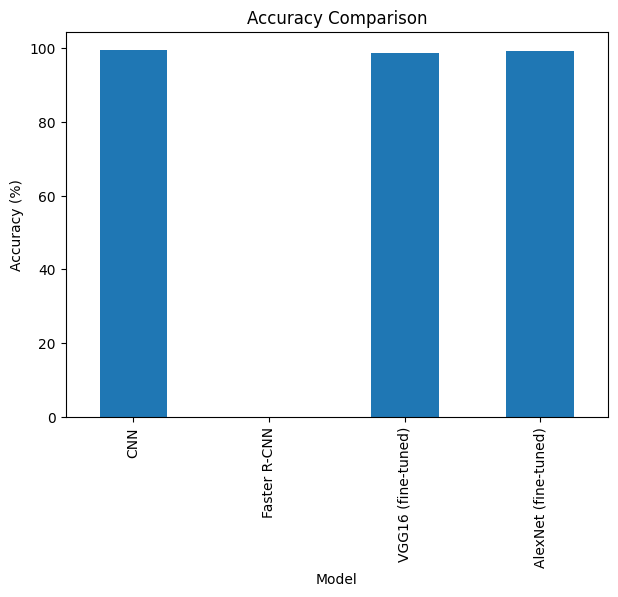

In [61]:
df_results.plot(x="Model", y="Accuracy (%)", kind="bar", figsize=(7,5), legend=False)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()


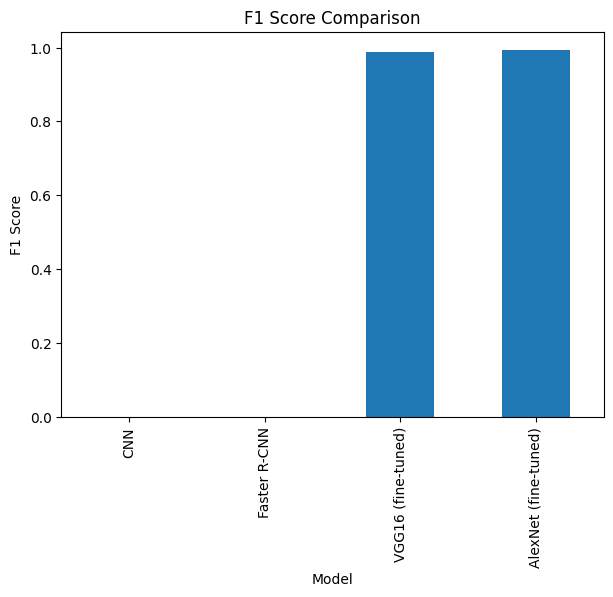

In [62]:
df_results.plot(x="Model", y="F1 Score", kind="bar", figsize=(7,5), legend=False)
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.show()


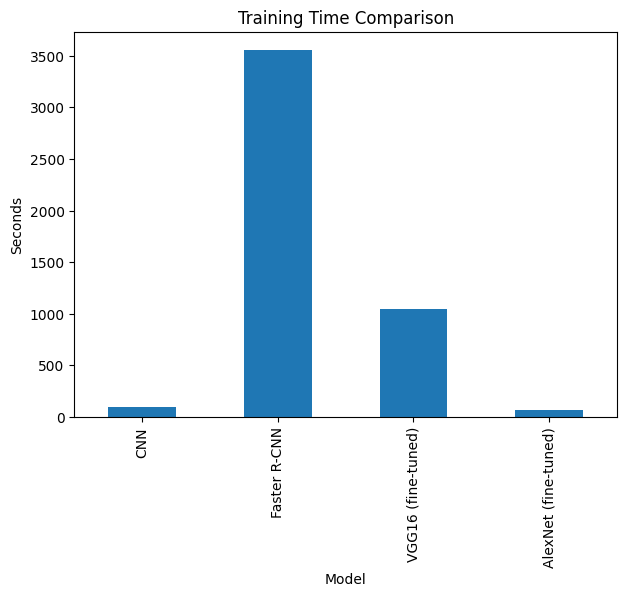

In [63]:
df_results.plot(x="Model", y="Training Time (sec)", kind="bar", figsize=(7,5), legend=False)
plt.title("Training Time Comparison")
plt.ylabel("Seconds")
plt.show()
